In [1]:
import numpy as np
import dxchange
import holotomo
import tifffile
import matplotlib.pyplot as plt
import sys
PLANCK_CONSTANT = 4.135667696e-18  # [keV*s]
SPEED_OF_LIGHT = 299792458  # [m/s]

%matplotlib inline


# Init data sizes and parametes of the PXM of ID16A

In [2]:
# energy = float(sys.argv[1])  # [keV] xray energy
# z1p = float(sys.argv[2])# positions of the probe and code for reconstruction
# # z1p = 270e-3# positions of the probe and code for reconstruction
# ill_feature_size = float(sys.argv[3])
# use_prb = sys.argv[4]=='True'
# use_code = sys.argv[5]=='True'
# ndist = int(sys.argv[6])
# niter = int(sys.argv[7])
# step = int(sys.argv[8])
# smooth = int(sys.argv[9])
# flg_show = False
###################
energy = 25  # [keV] xray energy
z1p = 12e-3# positions of the probe and code for reconstruction
# z1p = 270e-3# positions of the probe and code for reconstruction
ill_feature_size = 1e-6
use_prb = False
use_code = True
ndist = 1
smooth = 5
flg_show = True

###################
ne=256
pad=False
if ndist==1:
    pad=False
    ne = 256

niter = 10000
step = 64
flg_show = True
n = 256  # object size in each dimension
ntheta = 180  # number of angles (rotations)
pn = 256  # tomography chunk size for GPU processing
ptheta = 180  # holography chunk size for GPU processing

###################
flg = f'{n}_{ntheta}_{energy:.2f}_{z1p:.1e}_{ill_feature_size:.1e}_{use_prb}_{use_code}_{ndist}_{smooth}'
print(flg)


center = n/2  # rotation axis
theta = np.linspace(0, np.pi, ntheta).astype('float32')  # projection angles

# ID16a setup
voxelsize = 10e-9*2048/n  # object voxel size


wavelength = PLANCK_CONSTANT * SPEED_OF_LIGHT / energy
focusToDetectorDistance = 1.28

sx0 = 3.7e-4
z1 = np.array([4.584e-3, 4.765e-3, 5.488e-3, 6.9895e-3])[:ndist]-sx0
z1[:]=z1[0]
z2 = focusToDetectorDistance-z1
distances = (z1*z2)/focusToDetectorDistance
magnifications = focusToDetectorDistance/z1
norm_magnifications = magnifications/magnifications[0]
# scaled propagation distances due to magnified probes
distances = distances*norm_magnifications**2


z2p = z1-z1p
# magnification when propagating from the probe plane to the detector
magnificationsp = z1/z1p
# propagation distances after switching from the point source wave to plane wave,
distancesp = (z1p*z2p)/z1

norm_magnificationsp = magnificationsp/(z1p/z1[0])  # normalized magnifications
# scaled propagation distances due to magnified probes
distancesp = distancesp*norm_magnificationsp**2
distancesp = distancesp*(z1p/z1)**2

print(distances, distancesp)
print(distances+ distancesp)


256_180_25.00_1.2e-02_1.0e-06_False_True_1_5
[0.00420013] [-0.00273418]
[0.00146594]


## Read data

/data/vnikitin/modeling/data_3d_ald_syn_codes_256_180_25.00_1.2e-02_1.0e-06_False_True_1_5.tiff


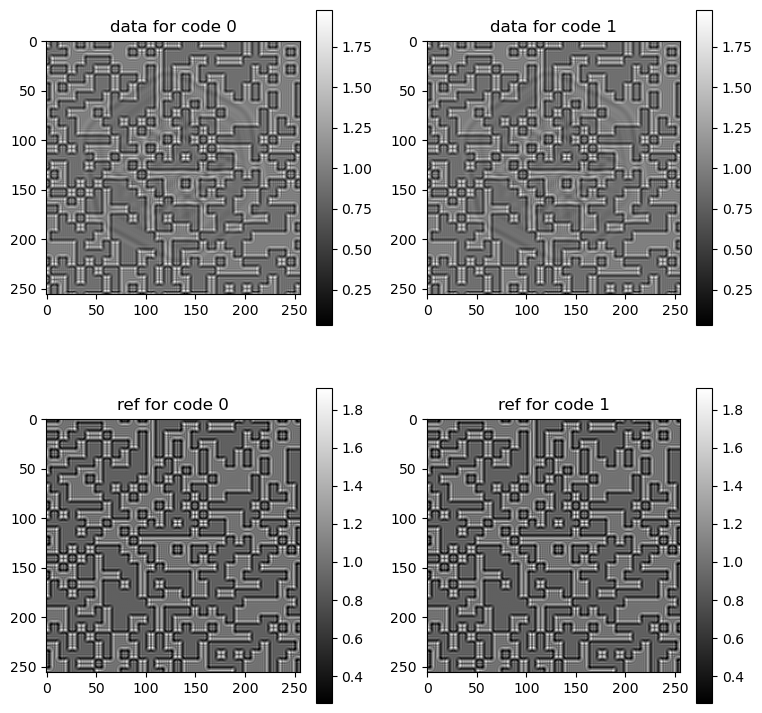

In [3]:
data0 = np.zeros([ndist,ntheta,n,n],dtype='float32')
ref0 = np.zeros([ndist,n,n],dtype='float32')
for k in range(ndist):
    print(f'/data/vnikitin/modeling/data_3d_ald_syn_codes_{flg}.tiff')
    data0[k] = dxchange.read_tiff(f'/data/vnikitin/modeling/data_3d_ald_syn_codes_{flg}_{k}.tiff')
    ref0[k] = dxchange.read_tiff(f'/data/vnikitin/modeling/ref_3d_ald_syn_codes_{flg}_{k}.tiff')


#SQRT
data0=np.sqrt(data0)
ref0=np.sqrt(ref0)

if flg_show:
    fig, axs = plt.subplots(2, 2, figsize=(9, 9))
    im=axs[0,0].imshow(data0[0,0],cmap='gray')
    axs[0,0].set_title('data for code 0')
    fig.colorbar(im)
    im=axs[0,1].imshow(data0[-1,0],cmap='gray')
    axs[0,1].set_title('data for code 1')
    fig.colorbar(im)
    im=axs[1,0].imshow(ref0[0],cmap='gray')
    axs[1,0].set_title('ref for code 0')
    fig.colorbar(im)
    im=axs[1,1].imshow(ref0[-1],cmap='gray')
    axs[1,1].set_title('ref for code 1')
    fig.colorbar(im)
    plt.show()

## Read the transmittance functions for the code

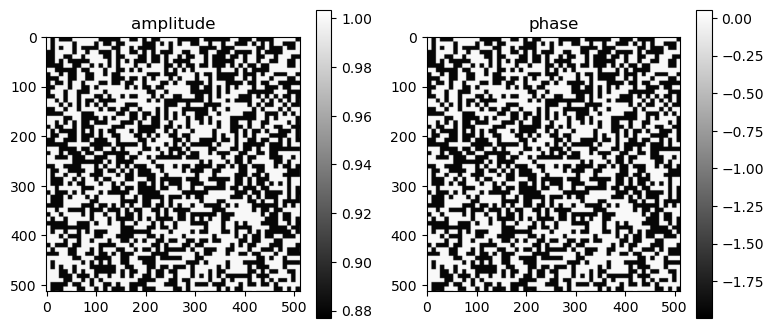

In [4]:
code = np.ones([1,2*n,2*n],dtype='complex64')
code[0] = (tifffile.imread(f'/data/vnikitin/modeling/psiill_abs_{flg}.tiff')*np.exp(1j* tifffile.imread(f'/data/vnikitin/modeling/psiill_angle_{flg}.tiff')))
if flg_show:
    fig, axs = plt.subplots(1, 2, figsize=(9, 4))
    im=axs[0].imshow(np.abs(code[0]),cmap='gray')
    axs[0].set_title('amplitude')
    fig.colorbar(im)
    im=axs[1].imshow(np.angle(code[0]),cmap='gray')
    axs[1].set_title('phase')
    fig.colorbar(im)

shifts = np.load(f'/data/vnikitin/modeling/shifts_{flg}.npy')
shifts_code = np.load(f'/data/vnikitin/modeling/shifts_code_{flg}.npy')


## Create a solver class for holography, note the class has additional parameters distances2 to be able to compute Fresnel propagation between the sample and probe

In [5]:
pslv = holotomo.SolverHolo(ntheta, n, ne, ptheta, voxelsize, energy, distances, norm_magnifications, distancesp,pad=pad)
pslv0 = holotomo.SolverHolo(1, n, ne, 1, voxelsize, energy, distances, norm_magnifications, distancesp,pad=pad) 


256
256


In [6]:
data = data0.copy()
ref = ref0.copy()
arr1 = np.pad(np.array(data[0]+1j*data[0]).astype('complex64'),((0,0),(ne//2-n//2,ne//2-n//2),(ne//2-n//2,ne//2-n//2)),'symmetric')

prb1 = np.array(ref[:]+1j*ref[:]).astype('complex64')
arr2 = pslv.fwd_holo_batch(arr1, prb1, code=code, shifts_code=shifts_code)
arr3 = pslv.adj_holo_batch(arr2, prb1, code=code, shifts_code=shifts_code)
prb3 = pslv.adj_holo_prb_batch(arr2,arr1, code=code, shifts_code=shifts_code)



print(np.sum(arr1*np.conj(arr3)))
print(np.sum(arr2*np.conj(arr2)))
print(np.sum(prb1*np.conj(prb3)))

(31594050-0.1435907j)
(31594068-4.5050027e-05j)
(31594052-0.23657227j)


## Conjugate gradient solver

In [7]:
import cupy as cp
def line_search(minf, gamma, fu, fu0, fd, fd0):
    """ Line search for the step sizes gamma"""
    while(minf(fu,fu0)-minf(fu+gamma*fd, fu0+gamma*fd0) < 0 and gamma > 1e-12):
        gamma *= 0.5
    if(gamma <= 1e-12):  # direction not found
        #print('no direction')
        gamma = 0
    return gamma

def cg_holo(pslv, pslv0, data, data_ref, init, init_prb,  piter,shifts, code=None, shifts_code=None, upd_psi=True, upd_prb=False,step=1,vis_step=1,gammapsi0=1,gammaprb0=2):
    """Conjugate gradients method for holography"""

    # minimization functional
    def minf(fpsi,fprb):
        f = cp.linalg.norm(cp.abs(fpsi)-data)**2            
        f += cp.linalg.norm(cp.abs(fprb)-data_ref)**2        
        return f        
    psi = init.copy()
    prb = init_prb.copy()
    gammapsi = gammapsi0
    gammaprb = gammaprb0
    psi_nil = psi[:1]*0+1
    shifts_nil = shifts[:,:1]*0
    shifts_code_nil = shifts_code[:,:1]*0
    
    for i in range(piter):
        if upd_psi:
            
            fpsi = pslv.fwd_holo(psi,prb,shifts,code, shifts_code)          
            d = -pslv.adj_holo(fpsi-data*cp.exp(1j*(cp.angle(fpsi))), prb,shifts)/cp.max(cp.abs(prb))**2#/ndist**2
            
            fd = pslv.fwd_holo(d, prb,shifts,code, shifts_code)     
            gammapsi = line_search(minf, gammapsi0, fpsi, 0, fd, 0)
            psi = psi+gammapsi*d
            
        if upd_prb:
            fprb = pslv.fwd_holo(psi,prb,shifts,code, shifts_code)
            fprb0 = pslv0.fwd_holo(psi_nil,prb,shifts_nil, code, shifts_code_nil)
            dprb = pslv.adj_holo_prb(fprb-data*cp.exp(1j*cp.angle(fprb)),psi,shifts,code, shifts_code)#/ndist**2
            dprb += pslv0.adj_holo_prb(fprb0-data_ref*cp.exp(1j*cp.angle(fprb0)),psi_nil,shifts_nil,code, shifts_code_nil)
            dprb*=-1/(pslv.ntheta+1)
            
            # line search
            fdprb = pslv.fwd_holo(psi, dprb,shifts,code, shifts_code)
            fdprb0 = pslv0.fwd_holo(psi_nil, dprb,shifts_nil,code, shifts_code_nil)
            
            gammaprb = line_search(minf, gammaprb0, fprb, fprb0, fdprb, fdprb0)
            prb = prb + gammaprb*dprb
            
        if i%step==0:
            fprb = pslv.fwd_holo(psi,prb,shifts,code, shifts_code)
            fprb0 = pslv0.fwd_holo(psi_nil,prb,shifts_nil,code, shifts_code_nil)            
            err=minf(fprb,fprb0)
            print(f'{i}) {gammapsi=} {gammaprb=}, {err=:1.5e}', flush=True)  

        if upd_prb==True and upd_psi==False and i%vis_step==0:  
            if flg_show:
                fig, axs = plt.subplots(1, 2, figsize=(10, 5))
                im=axs[0].imshow(cp.abs(prb[0]).get(),cmap='gray')
                axs[0].set_title('reconstructed amplitude')
                fig.colorbar(im)
                im=axs[1].imshow(cp.angle(prb[0]).get(),cmap='gray')
                axs[1].set_title('reconstructed phase')
                fig.colorbar(im)                
                plt.show()
        elif i%vis_step==0:
            if flg_show:  
                fig, axs = plt.subplots(1, 2, figsize=(10, 5))
                im=axs[0].imshow(cp.abs(psi[0]).get(),cmap='gray')
                axs[0].set_title('reconstructed amplitude')
                fig.colorbar(im)
                im=axs[1].imshow(cp.angle(psi[0]).get(),cmap='gray')
                axs[1].set_title('reconstructed phase')
                fig.colorbar(im)                
                plt.show()
            dxchange.write_tiff(cp.angle(psi).get(),f'/data/vnikitin/holo/3d_adl_syn_codes{flg}/{n}_{ntheta}_{ndist}/r{i:05}.tiff',overwrite=True)
            dxchange.write_tiff(cp.angle(psi[0]).get(),f'/data/vnikitin/holo/3d_adl_syn_codes{flg}/{n}_{ntheta}_{ndist}/o{i:05}.tiff',overwrite=True)
                        
            
    return psi,prb

def cg_holo_batch(pslv, pslv0, data,data_ref, init, prb_init, piter,shifts=None,code=None, shifts_code=None,upd_psi=True,upd_prb=False,step=1,vis_step=1,gammapsi0=1,gammaprb0=2):
    """Batch of CG solvers"""
    
    res = np.zeros([pslv.ntheta, pslv.ne, pslv.ne], dtype='complex64')
    prb_init_gpu = cp.array(prb_init)                
    codes_gpu = cp.array(code)
    for ids in holotomo.utils.chunk(range(pslv.ntheta), pslv.ptheta):
        # copy data part to gpu
        data_gpu = cp.array(data[:,ids])
        data_ref_gpu = cp.array(data_ref)
        
        init_gpu = cp.array(init[ids])
        shifts_gpu = cp.array(shifts[:,ids])        
        shift_codes_gpu = cp.array(shifts_code[:,ids])
        
        # Radon transform
        res_gpu,res_prb_gpu = cg_holo(pslv, pslv0, data_gpu,data_ref_gpu, init_gpu,prb_init_gpu, piter,shifts_gpu,codes_gpu,shift_codes_gpu,upd_psi, upd_prb,step,vis_step,gammapsi0,gammaprb0)
        # copy result to cpu
        res[ids] = res_gpu.get()
        res_prb = res_prb_gpu.get()
    return res,res_prb



# Find the probe approximation

256
256
0) gammapsi=0.5 gammaprb=1, err=6.54460e-09


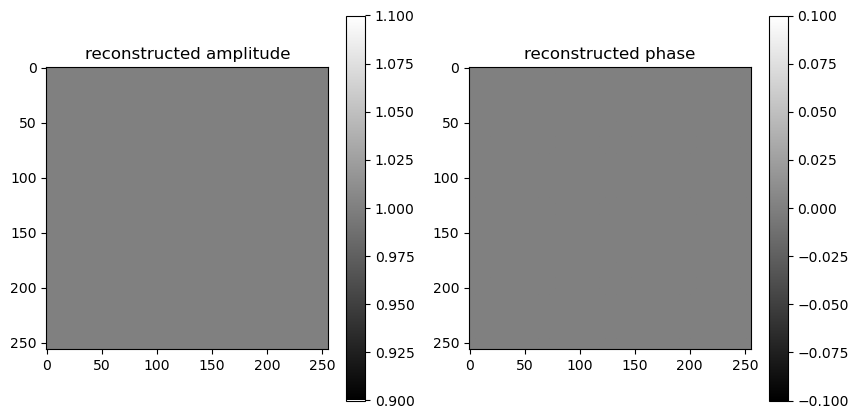

16) gammapsi=0.5 gammaprb=1, err=6.53491e-09
32) gammapsi=0.5 gammaprb=1, err=6.53429e-09


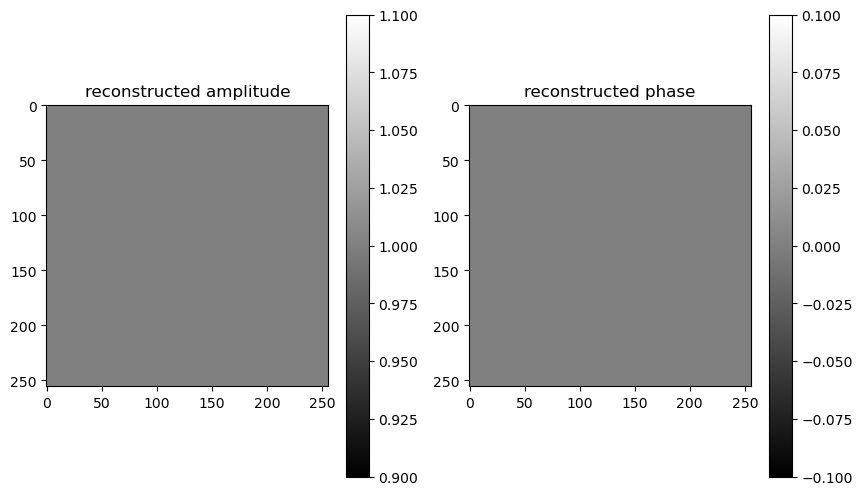

In [8]:
pslv = holotomo.SolverHolo(ntheta, n, ne, ptheta, voxelsize, energy, distances, norm_magnifications, distancesp,pad=pad)
pslv0 = holotomo.SolverHolo(1, n, ne, 1, voxelsize, energy, distances, norm_magnifications, distancesp,pad=pad)

rec = np.ones([1,ne,ne],dtype='complex64')
rec_prb = np.ones([ndist,n,n],dtype='complex64')        
data_ref = ref[:,np.newaxis]
shifts_ref = np.array(shifts)[:,:1]*0
shifts_codes_ref = np.array(shifts_code)[:,:1]*0
_,rec_prb0 = cg_holo_batch(pslv0, pslv0, data_ref, data_ref, rec, rec_prb, 33, shifts_ref, code, shifts_codes_ref, False,use_prb,16,35,0.5,1)

fig, axs = plt.subplots(1, 2, figsize=(10, 6))
im=axs[0].imshow(np.abs(rec_prb0[0]),cmap='gray')
axs[0].set_title('reconstructed amplitude')
fig.colorbar(im)
im=axs[1].imshow(np.angle(rec_prb0[0]),cmap='gray')
axs[1].set_title('reconstructed phase')
fig.colorbar(im)

0) gammapsi=0.5 gammaprb=1, err=2.08099e+04


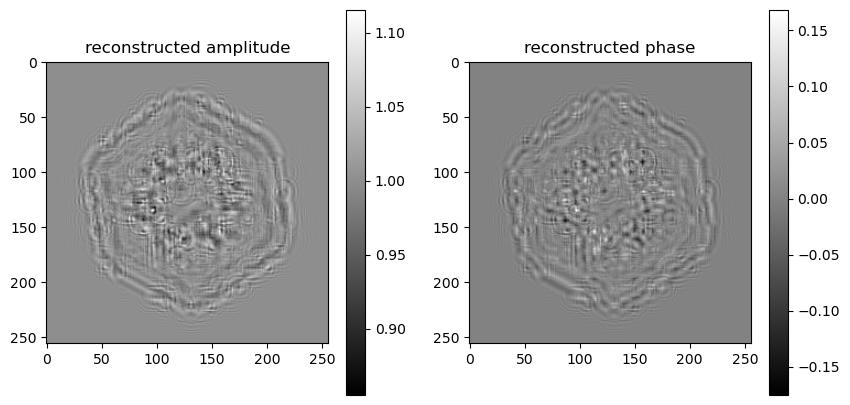

32) gammapsi=1.9073486328125e-06 gammaprb=1, err=2.05518e+04


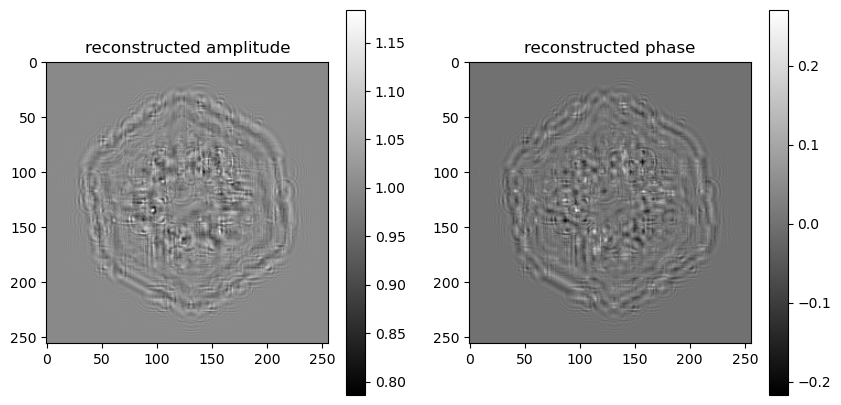

64) gammapsi=9.5367431640625e-07 gammaprb=1, err=2.05520e+04


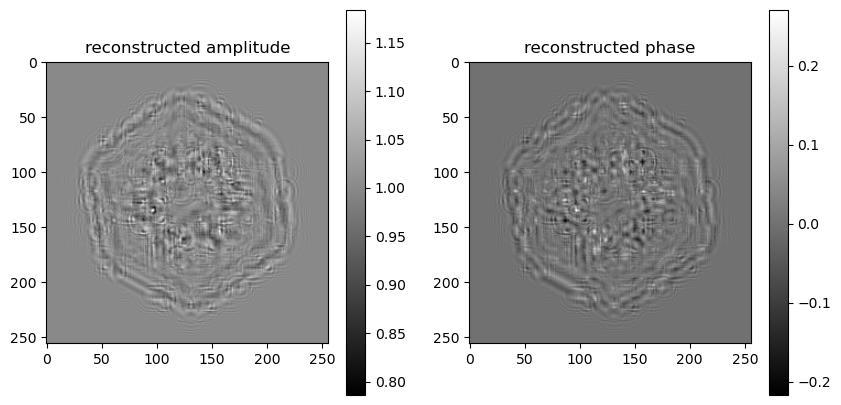

In [9]:
shifts_rec = cp.array(shifts/norm_magnifications[:,np.newaxis,np.newaxis])
rec1 = np.ones([ntheta,ne,ne],dtype='complex64')
# # use only the abs value of the probe as initial guess
rec_prb1 = rec_prb0.copy()
rec1,rec_prb1 = cg_holo_batch(pslv, pslv0, data, data_ref, rec1, rec_prb1, 65+0*(ndist>1), shifts_rec, code, shifts_code, True,use_prb,32,32,0.5,1)


In [10]:
def line_search_ext(minf, gamma, u, fu, fu0, d, fd, fd0):
    """ Line search for the step sizes gamma"""
    while(minf(u,fu,fu0)-minf(u+gamma*d, fu+gamma*fd, fu0+gamma*fd0) < 0 and gamma > 1e-12):
        gamma *= 0.5
    if(gamma <= 1e-12):  # direction not found
        #print('no direction')
        gamma = 0
    return gamma

# Forward operator for regularization (J)
def fwd_reg(u):
    res = cp.zeros([3, *u.shape], dtype='complex64', order='C')
    res[0, :, :, :-1] = u[:, :, 1:]-u[:, :, :-1]
    res[1, :, :-1, :] = u[:, 1:, :]-u[:, :-1, :]
    res[2, :-1, :, :] = u[1:, :, :]-u[:-1, :, :]
    res *= 2/np.sqrt(3)  # normalization
    return res

# Adjoint operator for regularization (J^*)
def adj_reg(gr):
    res = cp.zeros(gr.shape[1:], dtype='complex64', order='C')
    res[:, :, 1:] = gr[0, :, :, 1:]-gr[0, :, :, :-1]
    res[:, :, 0] = gr[0, :, :, 0]
    res[:, 1:, :] += gr[1, :, 1:, :]-gr[1, :, :-1, :]
    res[:, 0, :] += gr[1, :, 0, :]
    res[1:, :, :] += gr[2, 1:, :, :]-gr[2, :-1, :, :]
    res[0, :, :] += gr[2, 0, :, :]
    res *= -2/np.sqrt(3)  # normalization
    return res

# Regularizer problem
def solve_reg(u, mu, tau, alpha):
    z = fwd_reg(u)+mu/tau
    # Soft-thresholding
    za = cp.sqrt(cp.real(cp.sum(z*cp.conj(z), 0)))
    z[:, za <= alpha/tau] = 0
    z[:, za > alpha/tau] -= alpha/tau * \
        z[:, za > alpha/tau]/(za[za > alpha/tau])
    return z

def line_search(minf, gamma, fu, fd,gu,gd):
    """ Line search for the step sizes gamma"""
    while(minf(fu,gu)-minf(fu+gamma*fd,gu+gamma*gd) < 0 and gamma > 1e-12):
        gamma *= 0.5
    if(gamma <= 1e-12):  # direction not found
        #print('no direction')
        gamma = 0
    return gamma

# Update rho, tau for a faster convergence
def update_penalty(psi, h, h0, phi, e, e0, rho, tau):
    # rho
    r = cp.linalg.norm(psi - h)**2
    s = cp.linalg.norm(rho*(h-h0))**2
    if (r > 10*s):
        rho *= 2
    elif (s > 10*r):
        rho *= 0.5
    # tau
    r = cp.linalg.norm(phi - e)**2
    s = cp.linalg.norm(tau*(e-e0))**2
    if (r > 10*s):
        tau *= 2
    elif (s > 10*r):
        tau *= 0.5
    return rho, tau

def cg_holo_ext(pslv, pslv0, data, data_ref, init, init_prb,  piter, h, lamd, rho, \
                shifts=None, code=None, shifts_code=None, upd_psi=True, upd_prb=False,\
                gammapsi0=1,gammaprb0=2):
    """Conjugate gradients method for holography"""

    # minimization functional
    def minf(psi,fpsi,fprb):
        f = cp.linalg.norm(cp.abs(fpsi)-data)**2                    
        # f = cp.sum(cp.abs(fpsi)**2-2*data**2 * pslv.mlog(cp.abs(fpsi)))
        if isinstance(fprb,cp.ndarray):# is not 0:
            f += cp.linalg.norm(cp.abs(fprb)-data_ref)**2      
            # f += cp.sum(cp.abs(fprb)**2-2*data_ref**2 * pslv.mlog(cp.abs(fprb)))

        f += rho*cp.linalg.norm(h-psi+lamd/rho)**2        
        return f        
    psi = init.copy()
    prb = init_prb.copy()
    gammapsi = gammapsi0
    gammaprb = gammaprb0
    
    psi_nil = psi[:1]*0+1
    shifts_nil = shifts[:,:1]*0
    shifts_code_nil = shifts_code[:,0:1]*0
    
    for i in range(piter):
        if upd_psi:
            
            fpsi = pslv.fwd_holo(psi,prb,shifts,code, shifts_code)          
            grad = pslv.adj_holo(fpsi-data*cp.exp(1j*(cp.angle(fpsi))), prb,shifts,code, shifts_code)/cp.max(cp.abs(prb))**2#/ndist**2
            # grad =  pslv.adj_holo(fpsi-data**2*fpsi/(cp.abs(fpsi)**2+1e-32),prb,shifts,code, shifts_code)/cp.max(cp.abs(prb))**2
            grad += -rho*(h - psi + lamd/rho)
            # Dai-Yuan direction
            # d = -grad
            if i == 0:
                d = -grad
            else:
                d = -grad+cp.linalg.norm(grad)**2 / \
                    (1e-20+(cp.sum(cp.conj(d)*(grad-grad0))))*d
            grad0 = grad
            fd = pslv.fwd_holo(d, prb,shifts,code, shifts_code)     
            gammapsi = line_search_ext(minf, gammapsi0, psi, fpsi, 0, d, fd, 0)
            psi = psi+gammapsi*d
            
        if upd_prb:
            fprb = pslv.fwd_holo(psi,prb,shifts,code, shifts_code)
            fprb0 = pslv0.fwd_holo(psi_nil,prb,shifts_nil, code, shifts_code_nil)
            #gradprb = pslv.adj_holo_prb(fprb-data*cp.exp(1j*cp.angle(fprb)),psi,shifts,code, shifts_code)#/ndist**2
            #gradprb += pslv0.adj_holo_prb(fprb0-data_ref*cp.exp(1j*cp.angle(fprb0)),psi_nil,shifts_nil,code, shifts_code_nil)
            gradprb =  pslv.adj_holo_prb(fprb-data**2*fprb/(cp.abs(fprb)**2+1e-32),psi,shifts,code, shifts_code)
            gradprb +=  pslv0.adj_holo_prb(fprb0-data_ref**2*fprb/(cp.abs(fprb0)**2+1e-32),psi_nil,shifts_nil,code, shifts_code_nil)
            gradprb*=1/(pslv.ntheta+1)
            if i == 0:
                dprb = -gradprb
            else:
                dprb = -gradprb+cp.linalg.norm(gradprb)**2 / \
                    (1e-20+(cp.sum(cp.conj(dprb)*(gradprb-gradprb0))))*dprb
            gradprb0 = gradprb

            
            fdprb = pslv.fwd_holo(psi, dprb,shifts,code, shifts_code)
            fdprb0 = pslv0.fwd_holo(psi_nil, dprb,shifts_nil,code, shifts_code_nil)            
            gammaprb = line_search_ext(minf, gammaprb0, psi, fprb, fprb0, 0, fdprb, fdprb0)

            prb = prb + gammaprb*dprb   
        # print(gammapsi,gammaprb)               
    return psi,prb

def cg_tomo_ext(tslv, xi, xi1, K, init,rho, tau, titer,gamma0):
    # minimization functional
    def minf(KRu, gu):
        return rho*cp.linalg.norm(KRu-xi)**2+tau*cp.linalg.norm(gu-xi1)**2
    u = init.copy()
    for i in range(titer):
        KRu = K*tslv.fwd_tomo(u)
        gu = fwd_reg(u)
        grad = rho*tslv.adj_tomo(cp.conj(K)*(KRu-xi))+tau*adj_reg(gu-xi1)     
        # Dai-Yuan direction
        if i == 0:
            d = -grad
        else:
            d = -grad+cp.linalg.norm(grad)**2 / \
                ((cp.sum(cp.conj(d)*(grad-grad0))))*d
        grad0 = grad
        # line search
        gamma = line_search(minf, gamma0, KRu, K*tslv.fwd_tomo(d), gu, fwd_reg(d))
        # update step
        u = u + gamma*d
    return u

def take_lagr_gpu(pslv,pslv0, psi, prb, phi, data, data_ref, shifts, code, shifts_code, h, e, lamd,mu, alpha, rho, tau):
    lagr = cp.zeros(8, dtype="float32")
    fpsi = pslv.fwd_holo(psi,prb,shifts, code, shifts_code)    
    lagr[0] = cp.linalg.norm(np.abs(fpsi)-data)**2            

    psi_nil = psi[:1]*0+1
    shifts_nil = shifts[:,:1]*0
    shifts_code_nil = shifts_code[:,0:1]*0
    fprb = pslv0.fwd_holo(psi_nil,prb, shifts_nil, code, shifts_code_nil)      

    lagr[1] = cp.linalg.norm(cp.abs(fprb)-data_ref)**2      
    lagr[2] = alpha*cp.sum(np.sqrt(cp.real(cp.sum(phi*cp.conj(phi), 0))))
    lagr[3] = 2*cp.sum(np.real(cp.conj(mu)*(e-phi)))
    lagr[4] = tau*cp.linalg.norm(e-phi)**2        
    lagr[5] = 2*cp.sum(cp.real(cp.conj(lamd)*(h-psi)))    
    lagr[6] = rho*cp.linalg.norm(h-psi)**2    
    lagr[7] = cp.sum(lagr[0:7])

    return lagr

def admm_gpu(pslv, pslv0, tslv, data,data_ref, h, e, psi, prb, phi, shifts, code, shifts_code, lamd, mu, u,alpha, piter, titer, niter,step=1,viz_step=1):
    rho = 0.5
    tau = 0.5
    for m in range(niter):
        h0 = h.copy()
        e0 = e.copy()
        # keep previous iteration for penalty updates
        psi,prb = cg_holo_ext(pslv, pslv0, data, data_ref, psi, prb, piter,h, lamd,rho,\
                                shifts,code,shifts_code,True,use_prb,1,2)
        xi = pslv.logtomo(psi-lamd/rho)
        # tomography problem
        K = psi-lamd/rho
        K /= cp.amax(cp.abs(K))
        xi = K*(pslv.logtomo(psi-lamd/rho))
        xi1 = phi-mu/tau

        xi = cp.pad(xi,((0,0),(0,0),(ne//4,ne//4)),'edge')
        K = cp.pad(K,((0,0),(0,0),(ne//4,ne//4)),'edge')
        u = cg_tomo_ext(tslv, xi, xi1, K, u, rho, tau, titer,1)
        phi = solve_reg(u, mu, tau, alpha)
        # h,e updates        
        h = pslv.exptomo(tslv.fwd_tomo(u))[:,:,ne//4:-ne//4]       
        e = fwd_reg(u)
        
        # lambda, mu updates
        lamd += rho * (h-psi)        
        mu += tau * (e-phi)        

        if m%viz_step==0:
            if flg_show:
                fig, axs = plt.subplots(1, 2, figsize=(10, 5))                
                im=axs[0].imshow(cp.angle(psi[0]).get(), cmap='gray')
                axs[0].set_title('reconstructed phase')
                fig.colorbar(im)
                im=axs[1].imshow(cp.abs(psi[0]).get(), cmap='gray')
                axs[1].set_title('reconstructed abs')
                fig.colorbar(im)                
                plt.show()
                fig, axs = plt.subplots(1, 2, figsize=(10, 5))
                im=axs[0].imshow(cp.real(u[:,ne//2+ne//4,ne//4:-ne//4]).get(), cmap='gray')
                axs[0].set_title('delta')
                fig.colorbar(im)
                im=axs[1].imshow(cp.imag(u[:,ne//2+ne//4,ne//4:-ne//4]).get(), cmap='gray')
                axs[1].set_title('beta')
                fig.colorbar(im)                
                plt.show()
            dxchange.write_tiff(cp.angle(psi).get(),   f'/data/vnikitin/modeling/3d_ald_syn_codes{flg}/psi/r{m:05}.tiff',overwrite=True)
            dxchange.write_tiff(cp.angle(psi[0]).get(),f'/data/vnikitin/modeling/3d_ald_syn_codes{flg}/psi/o{m:05}.tiff',overwrite=True)
            dxchange.write_tiff(cp.imag(u[:,ne//4:-ne//4,ne//4:-ne//4]).get(),      f'/data/vnikitin/modeling/3d_ald_syn_codes{flg}/uim/r{m:05}.tiff',overwrite=True)
            dxchange.write_tiff(cp.imag(u[:,ne//2+ne//4,ne//4:-ne//4]).get(), f'/data/vnikitin/modeling/3d_ald_syn_codes{flg}/uim/o{m:05}.tiff',overwrite=True)
            dxchange.write_tiff(cp.real(u[:,ne//4:-ne//4,ne//4:-ne//4]).get(),      f'/data/vnikitin/modeling/3d_ald_syn_codes{flg}/ure/r{m:05}.tiff',overwrite=True)
            dxchange.write_tiff(cp.real(u[:,ne//2+ne//4,ne//4:-ne//4]).get(), f'/data/vnikitin/modeling/3d_ald_syn_codes{flg}/ure/o{m:05}.tiff',overwrite=True)
        # Lagrangians difference between two iterations
        if m%step==0:            
            # lagr = take_lagr_gpu(pslv,pslv0, psi,prb, data, data_ref, shifts, code, shifts_code,h, lamd,rho)
            lagr = take_lagr_gpu(pslv,pslv0, psi, prb, phi, data, data_ref, shifts, code, shifts_code, h, e, lamd,mu, alpha, rho, tau)
            print("%d/%d) rho=%f, tau=%f %.2e %.2e %.2e %.2e %.2e %.2e %.2e, Sum: %.2e" %(m, niter, rho, tau, *lagr),flush=True)
        
        #rho,tau = update_penalty(psi,h,h0,phi, e,e0,rho,tau)        
    return u, psi, prb

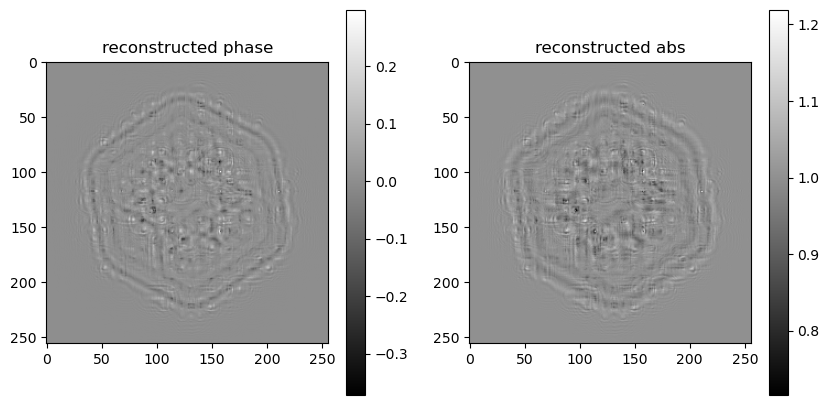

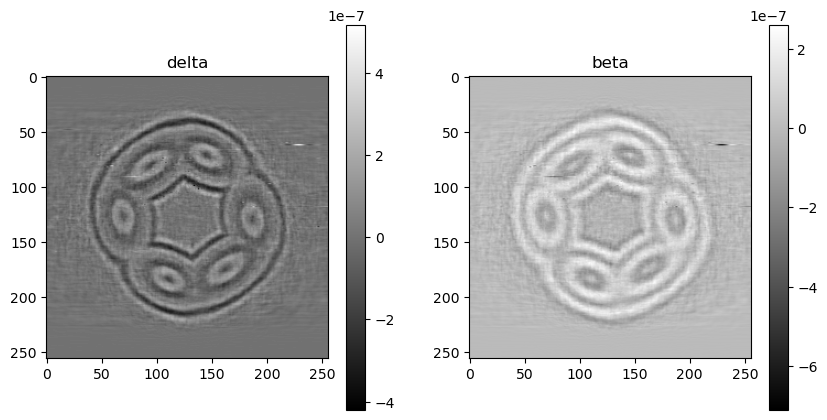

0/10000) rho=0.500000, tau=0.500000 5.70e+03 3.25e-09 0.00e+00 8.48e-08 4.24e-08 5.60e+03 2.80e+03, Sum: 1.41e+04


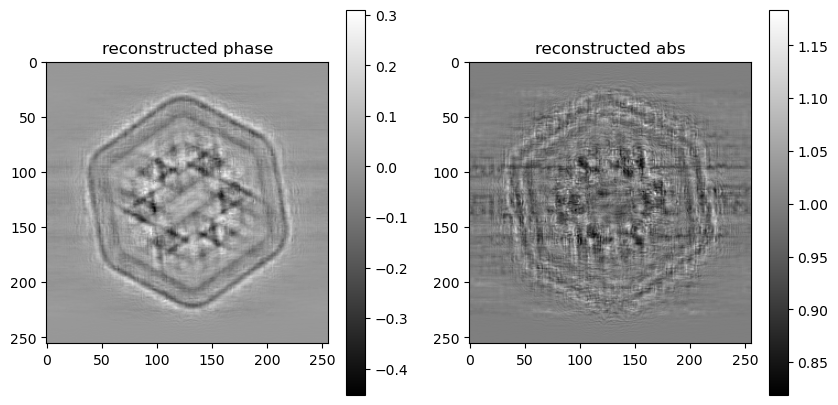

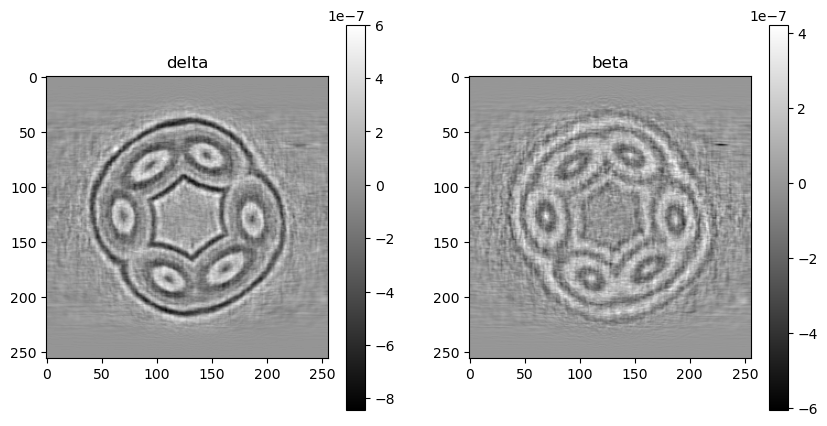

4/10000) rho=0.500000, tau=0.500000 2.66e+03 3.26e-09 0.00e+00 1.45e-06 2.10e-07 8.54e+02 2.04e+03, Sum: 5.56e+03


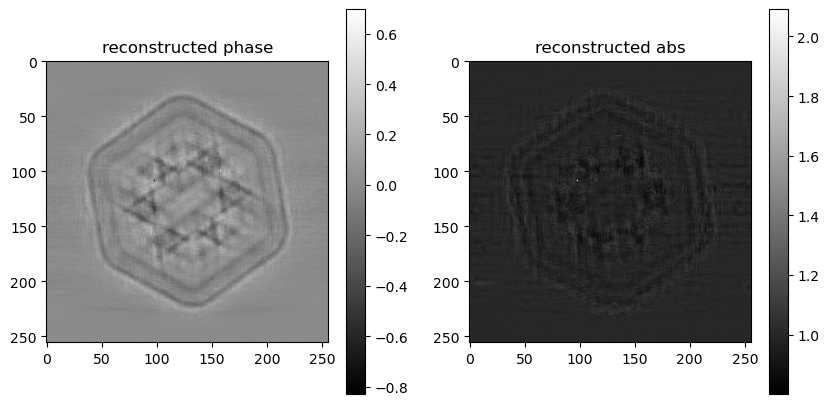

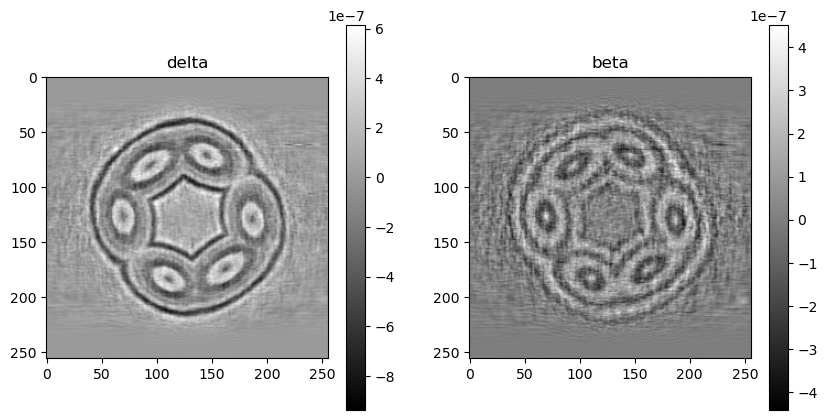

8/10000) rho=0.500000, tau=0.500000 2.12e+03 3.26e-09 0.00e+00 3.23e-06 2.20e-07 1.88e+03 1.75e+03, Sum: 5.75e+03


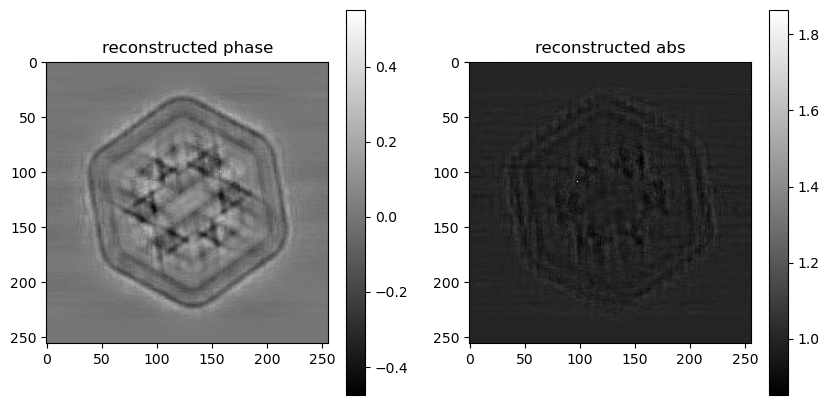

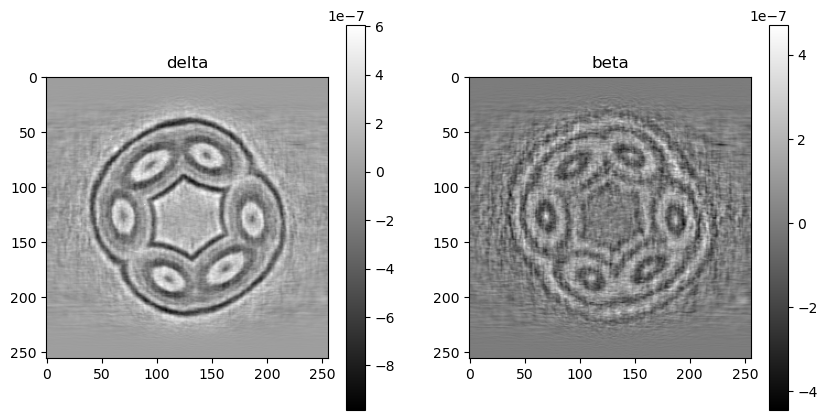

12/10000) rho=0.500000, tau=0.500000 1.43e+03 3.25e-09 0.00e+00 4.79e-06 2.10e-07 6.12e+02 6.83e+02, Sum: 2.73e+03


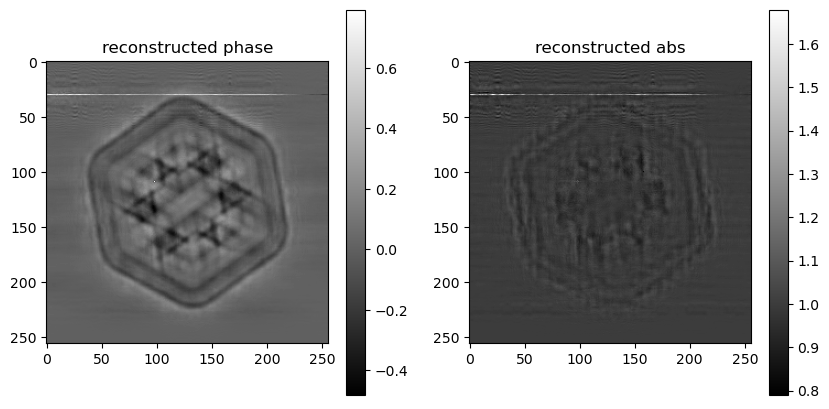

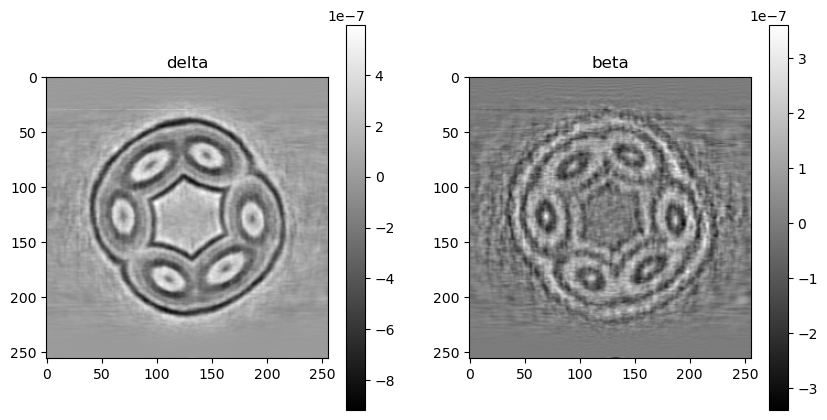

16/10000) rho=0.500000, tau=0.500000 3.93e+03 3.26e-09 0.00e+00 3.32e-06 1.07e-07 4.03e+03 6.05e+03, Sum: 1.40e+04


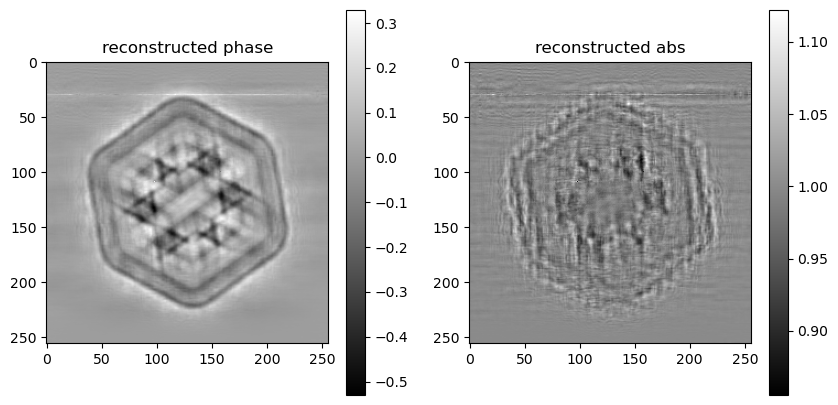

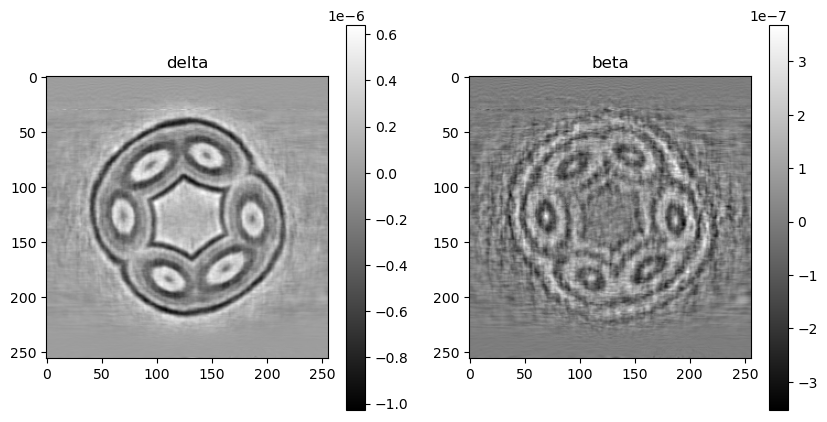

20/10000) rho=0.500000, tau=0.500000 2.29e+03 3.27e-09 0.00e+00 5.22e-06 1.40e-07 3.97e+02 9.29e+02, Sum: 3.62e+03


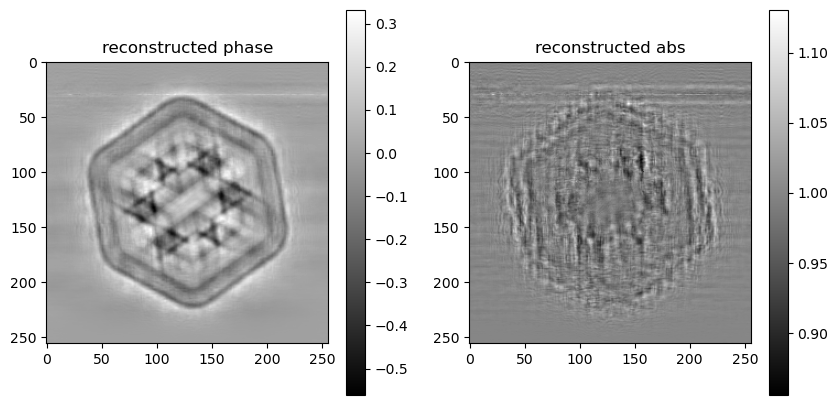

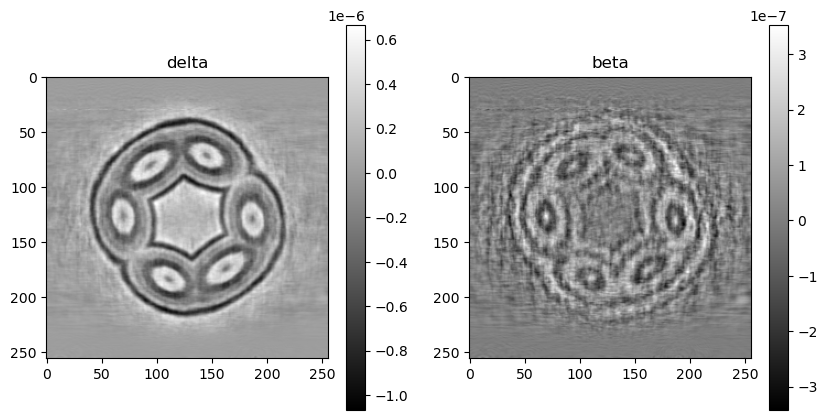

24/10000) rho=0.500000, tau=0.500000 1.46e+03 3.27e-09 0.00e+00 6.29e-06 1.39e-07 6.19e+02 6.90e+02, Sum: 2.77e+03


KeyboardInterrupt: 

In [11]:
tslv = holotomo.SolverTomo(theta, ntheta, ne, ne+ne//2, pn*ne//n, center*ne//n+ne/4)
# xi = cp.array(pslv.logtomo(rec1))
# ureg = cp.zeros([ne,ne,ne],dtype='complex64')
# ureg = tslv.cg_tomo(xi,ureg,64,0.5)
# dxchange.write_tiff(cp.imag(ureg).get(),      f'/data/vnikitin/modeling/3d_ald_syn_codes{flg}/uregim/r.tiff',overwrite=True)
# dxchange.write_tiff(cp.imag(ureg[69]).get(), f'/data/vnikitin/modeling/3d_ald_syn_codes{flg}/uregim/o.tiff',overwrite=True)
# dxchange.write_tiff(cp.real(ureg).get(),      f'/data/vnikitin/modeling/3d_ald_syn_codes{flg}/uregre/r.tiff',overwrite=True)
# dxchange.write_tiff(cp.real(ureg[69]).get(), f'/data/vnikitin/modeling/3d_ald_syn_codes{flg}/uregre/o.tiff',overwrite=True)
# dxchange.write_tiff(np.angle(rec1),   f'/data/vnikitin/modeling/3d_ald_syn_codes{flg}/psireg/r.tiff',overwrite=True)
# dxchange.write_tiff(np.angle(rec1[0]),f'/data/vnikitin/modeling/3d_ald_syn_codes{flg}/psireg/o.tiff',overwrite=True)
            

h = cp.ones([ntheta,ne,ne],dtype='complex64')
e = cp.zeros([3,ne,ne+ne//2,ne+ne//2],dtype='complex64')
lamd = cp.zeros([ntheta,ne,ne],dtype='complex64')
mu = cp.zeros([3,ne,ne+ne//2,ne+ne//2],dtype='complex64')
rec = cp.ones([ntheta,ne,ne],dtype='complex64')
phi = cp.zeros([3,ne,ne+ne//2,ne+ne//2],dtype='complex64')
# rec = cp.array(rec1).copy()
# h = cp.array(rec1).copy()

rec_prb = cp.array(rec_prb1).copy()
urec = cp.zeros([ne,ne+ne//2,ne+ne//2],dtype='complex64')
data_gpu = cp.array(data)
data_ref_gpu = cp.array(data_ref)
shifts_gpu = cp.array(shifts)
code_gpu = cp.array(code)
shifts_code_gpu = cp.array(shifts_code)

# rec_abs = dxchange.read_tiff(f'/data/vnikitin/modeling/psi_abs_3d_ald_syn_codes_{flg}.tiff')
# rec_angle = dxchange.read_tiff(f'/data/vnikitin/modeling/psi_angle_3d_ald_syn_codes_{flg}.tiff')
# rec = cp.array(rec_abs*np.exp(1j*rec_angle))
# h = cp.array(rec_abs*np.exp(1j*rec_angle))


# xi = cp.array(pslv.logtomo(rec))
# xi = cp.pad(xi,((0,0),(64,64),(64,64)))
# ureg = cp.zeros([ne,ne,ne],dtype='complex64')
# tslv = holotomo.SolverTomo(theta, ntheta, ne+128, ne+128, pn+128, center*ne//n+64)
# ureg = tslv.cg_tomo(xi,ureg,32,0.5)
alpha = 1e-4
urec, rec, rec_prb = admm_gpu(pslv, pslv0, tslv, data_gpu, data_ref_gpu, h, e,  rec, rec_prb, phi, shifts_gpu,code_gpu,shifts_code_gpu, lamd, mu, urec, alpha, 4, 4, 10000,4,4)                             

In [ ]:
plt.imshow(urec[ne//2].real.get())